In [1]:
import pandas as pd
import json
import re
import spacy
import os

file = "multipleye_stimuli_experiment_RO.xlsx"
excel_path = "/content/" + file

In [2]:
df = pd.read_excel(excel_path)

stimuli = []
for _, row in df.iterrows():
    pages = []
    for col in df.columns:
        if col.startswith("page_") and pd.notna(row[col]):
            pages.append(str(row[col]).strip())
    stimuli.append({
        "stimulus_id": int(row["stimulus_id"]),
        "stimulus_name": row["stimulus_name"],
        "stimulus_type": row["stimulus_type"],
        "pages": pages
    })

len(stimuli)

12

In [3]:
json_file = os.path.splitext(file)[0] + ".json"

with open("/content/" + json_file, "w", encoding="utf-8") as f:
    json.dump(stimuli, f, indent=2, ensure_ascii=False)

print("saved", json_file)

saved multipleye_stimuli_experiment_RO.json


In [4]:
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text) #remove punctuation
    text = re.sub(r"\s+", " ", text).strip() #replace multiple spaces with only one
    return text

def ttr_from_text(text):
    doc = nlp(text)
    tokens = [t.text for t in doc if t.is_alpha]
    if not tokens:
        return 0.0, 0, 0
    return len(set(tokens)) / len(tokens), len(tokens), len(set(tokens))

In [5]:
rows = []

for stim in stimuli:
    sid = stim["stimulus_id"]
    sname = stim["stimulus_name"]

    #ttr for full text
    full = preprocess(" ".join(stim["pages"]))
    ttr_full, n_tok_full, n_types_full = ttr_from_text(full)
    rows.append({
        "stimulus_id": sid,
        "stimulus_name": sname,
        "scope": "full_text",
        "page": None,
        "num_tokens": n_tok_full,
        "num_types": n_types_full,
        "ttr": ttr_full
    })

    #ttr for every page
    for i, page in enumerate(stim["pages"], start=1):
        ptext = preprocess(page)
        ttr_page, n_tok_page, n_types_page = ttr_from_text(ptext)
        rows.append({
            "stimulus_id": sid,
            "stimulus_name": sname,
            "scope": "page",
            "page": i,
            "num_tokens": n_tok_page,
            "num_types": n_types_page,
            "ttr": ttr_page
        })

In [10]:
csv_file = os.path.splitext(file)[0] + "_ttr.csv"

out = pd.DataFrame(rows).sort_values(["stimulus_id", "scope", "page"], ignore_index=True)
out.to_csv("/content/" + csv_file, index=False, encoding="utf-8")

print("saved", csv_file)
out.head(12)

saved multipleye_stimuli_experiment_RO_ttr.csv


,stimulus_id,stimulus_name,scope,page,num_tokens,num_types,ttr
0,1,PopSci_MultiplEYE,full_text,NaN,978,418,0.427403
1,1,PopSci_MultiplEYE,page,1.0,89,67,0.752809
2,1,PopSci_MultiplEYE,page,2.0,101,67,0.663366
3,1,PopSci_MultiplEYE,page,3.0,76,58,0.763158
4,1,PopSci_MultiplEYE,page,4.0,73,54,0.739726
5,1,PopSci_MultiplEYE,page,5.0,89,66,0.741573
6,1,PopSci_MultiplEYE,page,6.0,96,67,0.697917
7,1,PopSci_MultiplEYE,page,7.0,91,72,0.791209
8,1,PopSci_MultiplEYE,page,8.0,101,79,0.782178
9,1,PopSci_MultiplEYE,page,9.0,113,80,0.707965


In [12]:
import pandas as pd

eng = pd.read_csv("/content/multipleye_stimuli_experiment_en_ttr.csv")
ro  = pd.read_csv("/content/multipleye_stimuli_experiment_RO_ttr.csv")
eng["lang"] = "English"
ro["lang"]  = "Romanian"

data = pd.concat([eng, ro], ignore_index=True)
full_texts = data[data["scope"] == "full_text"]

In [14]:
comp = full_texts.pivot_table(
    index="stimulus_id",
    columns="lang",
    values="ttr"
).reset_index()

comp

lang,stimulus_id,English,Romanian
0,1,0.410319,0.427403
1,2,0.449541,0.514589
2,3,0.432584,0.424161
3,4,0.458586,0.505792
4,6,0.475442,0.485226
5,7,0.537736,0.500000
6,8,0.462500,0.505014
7,9,0.488525,0.522321
8,10,0.428913,0.441372
9,11,0.434540,0.508197


In [15]:
avg = full_texts.groupby("lang")["ttr"].mean()
print("Average TTR values:")
print(avg)

Average TTR values:
lang
English     0.484279
Romanian    0.503167
Name: ttr, dtype: float64


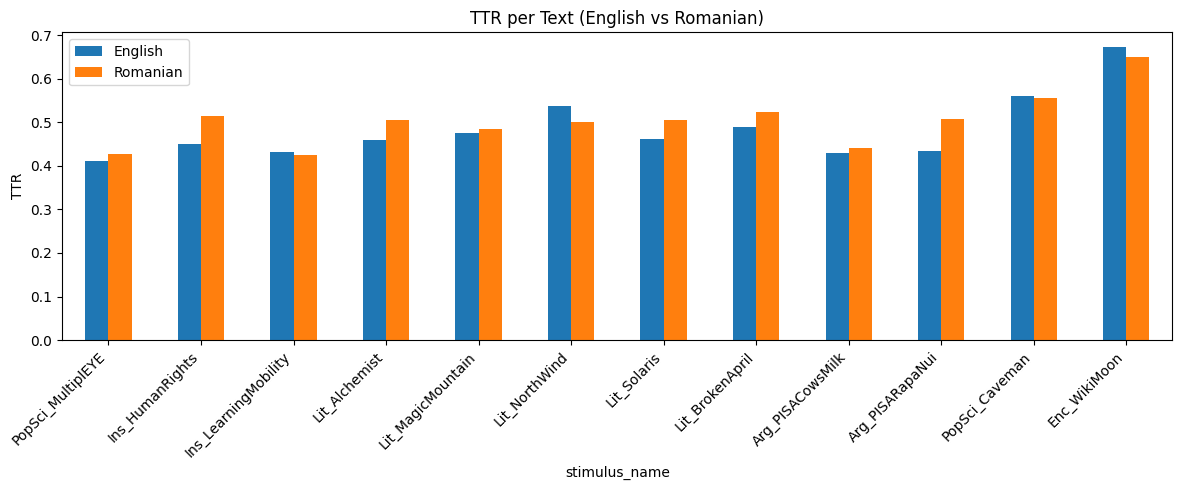

In [22]:
import matplotlib.pyplot as plt

comp = full_texts.pivot_table(
    index="stimulus_id",
    columns="lang",
    values="ttr"
).reset_index()

comp = comp.merge(
    full_texts[["stimulus_id", "stimulus_name"]].drop_duplicates(),
    on="stimulus_id",
    how="left"
)

comp.plot(
    x="stimulus_name",
    y=["English", "Romanian"],
    kind="bar",
    figsize=(12,5)
)

plt.ylabel("TTR")
plt.title("TTR per Text (English vs Romanian)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()